In [109]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import os
import sidetable 
import warnings
import dateutil
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
# To view all rows and columns while displaying a dataframe.
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Understanding the Data


In [5]:
# Read in the FullRaw
os.chdir("I:/My Machine Learning/My Python projects/Ecommerce Analytics")
fullRaw = pd.read_excel("E-com_Data.xlsx")
print('Our dataset has {} rows and {} columns'.format(fullRaw.shape[0], fullRaw.shape[1]))

Our dataset has 537979 rows and 12 columns


In [6]:
# Renaming all the columns for ease of coding
fullRaw.columns = ['customer_id', 'item_code', 'invoice_no', 'date_of_purchase', 'quantity', 'time', 
                   'price_per_unit', 'total_sales',
             'location', 'is_cancelled', 'return_reason', 'sold as set']


In [7]:
def missing_values_table(df):
        # Total missing values
        missing_values = df.isnull().sum()
        
        # Percentage of missing values
        missing_values_percentage = 100 * (df.isnull().sum() / len(df))
        
        # Make a table with the results
        missing_value_table = pd.concat([missing_values, missing_values_percentage], axis=1)
        
        # Rename the columns
        missing_values_table_rename = missing_value_table.rename(columns = {0 : "Missing Values", 1 : "% of Total Values"})
        
        # Sort the table by percentage of missing descending
        missing_values_table_rename = missing_values_table_rename[
            missing_values_table_rename.iloc[:,1] != 0].sort_values(
        "% of Total Values", ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(missing_values_table_rename.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return missing_values_table_rename

In [8]:
# Checking the missing values
missing_values_table(fullRaw)

Your selected dataframe has 12 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
sold as set,537979,100.0
is_cancelled,529634,98.4
return_reason,529631,98.4
customer_id,133790,24.9


## Data Cleaning and Preprossesing


In [9]:
# To show the missing values
perc_null_cid=(fullRaw['customer_id'].isnull().sum()/fullRaw['customer_id'].shape[0])*100
print(f'percentage of null values in customer_id column is : {perc_null_cid.round(2)}% ')
print(fullRaw['customer_id'].nunique())

percentage of null values in customer_id column is : 24.87% 
4349


In [10]:
# While looking at the number of null values in the dataframe, it is interesting to note that  ∼ 25% 
# of the entries are not assigned to a particular customer. With the data available, it is impossible to 
# impute values for the user and these entries are thus useless for the current exercise so dropping them.
fullRaw.dropna(subset=['customer_id'],axis=0,inplace=True)

In [11]:
# Imputing 'is_cancelled'
fullRaw['is_cancelled']=np.where(fullRaw['total_sales']<0,'TRUE','FALSE')

In [12]:
# Dropping 'Sold as set'
fullRaw=fullRaw.drop(['sold as set'],axis=1)

In [13]:
# Imputing 'return_reason'
fullRaw['return_reason']=np.where(fullRaw['is_cancelled']=='TRUE','Not Satisfied','Satisfied')

In [14]:
missing_values_table(fullRaw)

Your selected dataframe has 11 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [15]:
# Checking the duplicate entries and deleting them
print('Duplicate entries: {}'.format(fullRaw.duplicated().sum()))
fullRaw.drop_duplicates(inplace=True)

Duplicate entries: 8


In [16]:
fullRaw.head(10)

,customer_id,item_code,invoice_no,date_of_purchase,quantity,time,price_per_unit,total_sales,location,is_cancelled,return_reason
0,4355.0,15734,398177,2017-10-29,6,15:36:00,321.0,1926.0,Location 1,FALSE,Satisfied
1,4352.0,14616,394422,2017-10-05,2,14:53:00,870.0,1740.0,Location 1,FALSE,Satisfied
2,4352.0,14614,394422,2017-10-12,2,14:53:00,933.0,1866.0,Location 1,FALSE,Satisfied
3,4352.0,85014B,388633,2017-08-22,3,14:47:00,623.0,1869.0,Location 1,FALSE,Satisfied
4,4352.0,15364,394422,2017-10-10,2,14:53:00,944.0,1888.0,Location 1,FALSE,Satisfied
5,4349.0,14618,397122,2017-10-27,1,12:43:00,256.0,256.0,Location 1,FALSE,Satisfied
6,4343.0,15364,368432,2017-02-13,-4,14:46:00,922.0,-3688.0,Location 1,TRUE,Not Satisfied
7,4341.0,85014B,377109,2017-05-14,3,09:22:00,677.0,2031.0,Location 1,FALSE,Satisfied
8,4341.0,85014A,377109,2017-05-12,3,09:22:00,692.0,2076.0,Location 1,FALSE,Satisfied
9,4341.0,85014B,390217,2017-09-07,6,14:47:00,670.0,4020.0,Location 1,FALSE,Satisfied


In [18]:
# Unique customer id values
fullRaw['customer_id'].nunique()

4349

In [17]:
# Percentage of cancelled orders and you see that 2% of the orders are 'cancelled orders'
print(((fullRaw['is_cancelled']=='TRUE').sum()/fullRaw['is_cancelled'].shape[0])*100,"%")

2.02458799399279 %


In [19]:
# Converting time from object datatype to datetimes
fullRaw['invoice_date']=fullRaw.apply(lambda r : pd.datetime.combine(r['date_of_purchase'],r['time']),1)

In [20]:
fullRaw.head()

,customer_id,item_code,invoice_no,date_of_purchase,quantity,time,price_per_unit,total_sales,location,is_cancelled,return_reason,invoice_date
0,4355.0,15734,398177,2017-10-29,6,15:36:00,321.0,1926.0,Location 1,FALSE,Satisfied,2017-10-29 15:36:00
1,4352.0,14616,394422,2017-10-05,2,14:53:00,870.0,1740.0,Location 1,FALSE,Satisfied,2017-10-05 14:53:00
2,4352.0,14614,394422,2017-10-12,2,14:53:00,933.0,1866.0,Location 1,FALSE,Satisfied,2017-10-12 14:53:00
3,4352.0,85014B,388633,2017-08-22,3,14:47:00,623.0,1869.0,Location 1,FALSE,Satisfied,2017-08-22 14:47:00
4,4352.0,15364,394422,2017-10-10,2,14:53:00,944.0,1888.0,Location 1,FALSE,Satisfied,2017-10-10 14:53:00


In [21]:
#Extract month and year together from column in pandas:
fullRaw['year_month']=pd.to_datetime(fullRaw['invoice_date']).dt.to_period('M')

#Extract month,year,day and hour separately from column 'invoice_date'
fullRaw['year']=fullRaw['invoice_date'].dt.year
fullRaw['month']=fullRaw['invoice_date'].dt.month
fullRaw['day']=fullRaw['invoice_date'].dt.day
fullRaw['hour']=fullRaw['invoice_date'].dt.hour


## Exploratory Data Analysis
 
Using the cleaner data, we will visually see.

 

In [23]:
# Summary statistics of object variables
fullRaw.describe(include=object).T

,count,unique,top,freq
item_code,404181,3659,85123A,2064
time,404181,769,13:35:00,1834
location,404181,20,Location 36,376345
is_cancelled,404181,2,FALSE,395998
return_reason,404181,2,Satisfied,395998


In [24]:
# Updated fullRaw. The 'total_sales' column contains the value of price x quantity for each identifier.
fullRaw.head()

,customer_id,item_code,invoice_no,date_of_purchase,quantity,time,price_per_unit,total_sales,location,is_cancelled,return_reason,invoice_date,year_month,year,month,day,hour
0,4355.0,15734,398177,2017-10-29,6,15:36:00,321.0,1926.0,Location 1,FALSE,Satisfied,2017-10-29 15:36:00,2017-10,2017,10,29,15
1,4352.0,14616,394422,2017-10-05,2,14:53:00,870.0,1740.0,Location 1,FALSE,Satisfied,2017-10-05 14:53:00,2017-10,2017,10,5,14
2,4352.0,14614,394422,2017-10-12,2,14:53:00,933.0,1866.0,Location 1,FALSE,Satisfied,2017-10-12 14:53:00,2017-10,2017,10,12,14
3,4352.0,85014B,388633,2017-08-22,3,14:47:00,623.0,1869.0,Location 1,FALSE,Satisfied,2017-08-22 14:47:00,2017-08,2017,8,22,14
4,4352.0,15364,394422,2017-10-10,2,14:53:00,944.0,1888.0,Location 1,FALSE,Satisfied,2017-10-10 14:53:00,2017-10,2017,10,10,14


### Is company’s performance improving or degrading over time? 

Company’s performance can be measured in many terms. Here, we will be analysing the performance by:

1. Growth in Revenue by Sales

2. Growth in Sales Quantity

3. Growth in Customer Base

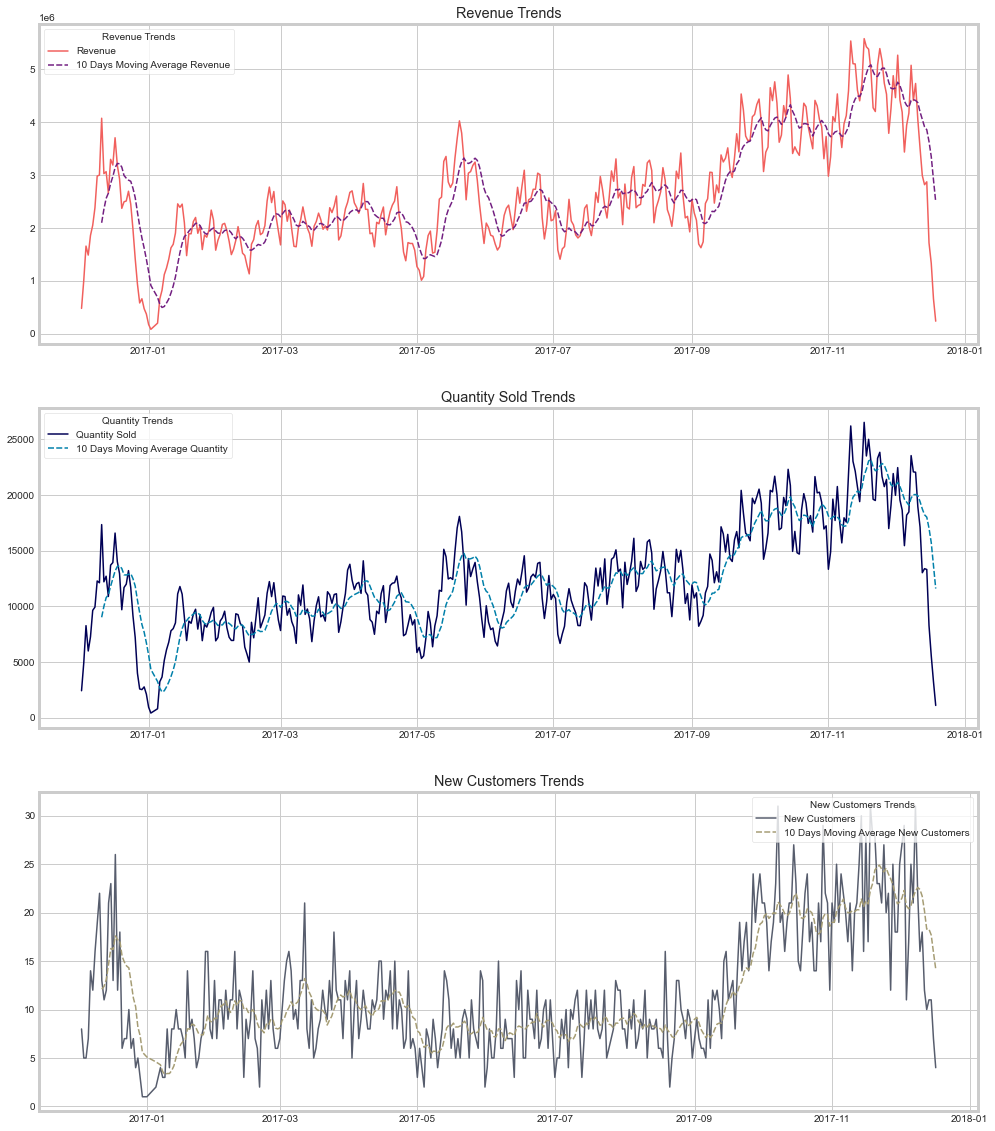

In [26]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(15,20))
rev = fullRaw[fullRaw['total_sales']>=0]

rev = rev.groupby(rev['date_of_purchase']).agg({'total_sales':'sum',
                                                  'quantity': 'sum',
                                                  'customer_id': 'count'})

rev['10 Days Moving Average Revenue'] = rev['total_sales'].rolling(10).mean()
rev['10 Days Moving Average Quantity'] = rev['quantity'].rolling(10).mean()

cust = fullRaw.groupby('customer_id').first().reset_index()[['customer_id','date_of_purchase']]
cust = cust.groupby(cust['date_of_purchase']).agg({'customer_id':'count'})
cust['10 Days Moving Average Quantity'] = cust['customer_id'].rolling(10).mean()

sns.set_style("whitegrid")
sns.lineplot(data=rev[['total_sales','10 Days Moving Average Revenue']], palette='magma_r', linewidth=1.5, ax=ax[0],legend=False)
ax[0].legend(title='Revenue Trends', loc='upper left', labels=['Revenue', '10 Days Moving Average Revenue'])
ax[0].title.set_text('Revenue Trends')
ax[0].set_xlabel('');

sns.lineplot(data=rev[['quantity','10 Days Moving Average Quantity']], palette='ocean', linewidth=1.5, ax=ax[1])
ax[1].legend(title='Quantity Trends', loc='upper left', labels=['Quantity Sold', '10 Days Moving Average Quantity'])
ax[1].title.set_text('Quantity Sold Trends')
ax[1].set_xlabel('');

sns.lineplot(data=cust, palette='cividis', linewidth=1.5, ax=ax[2])
ax[2].legend(title='New Customers Trends', loc='upper right', labels=['New Customers', '10 Days Moving Average New Customers'])
ax[2].title.set_text('New Customers Trends')
ax[2].set_xlabel('');

Here, you can see that the Revenue Trends and Quantity Sold trends are rising in a shallow manner. The rate of rising is shown to be in an increasing state between '2017-09' to after '2017-11', then it began decreasing, which is quite steep. But for 'New Customers Trends', you can see that the rise has been quite inelastic trends or a near constant trend until 2017-09, after which, it began rising again, which a similar fall like the above explained.
Off the graphs, you can therefore say that the period from '2017-09' to a little post '2017-11', business has been
good for the company. 

### Number of Units sold per location
Let us look at the sales in locations.
Here, you can see that Location 36 is shown to have the highest sale. 
Most businesses have warehouses of different sizes. But the business will have a main warehouse that houses a majority of stock and storage space. So either Location 36 is the biggest warehouse or the business is well-known in this area.

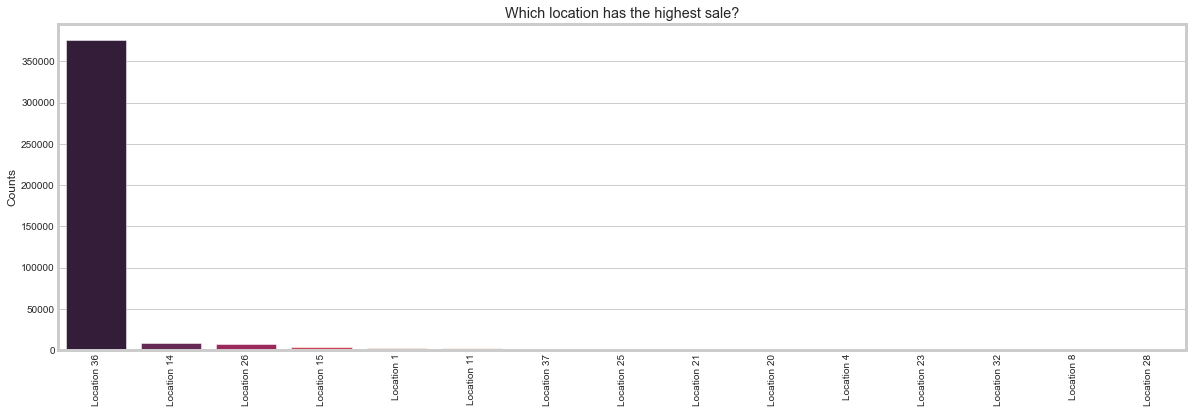

In [27]:
location_counts = fullRaw['location'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(location_counts.index, location_counts.values, palette=sns.color_palette("rocket"))
plt.ylabel("Counts")
plt.title("Which location has the highest sale?");
plt.xticks(rotation=90);

In [28]:
# Understanding Location
fullRaw.stb.freq(['location'],style=True,thresh=98.5)

,location,count,percent,cumulative_count,cumulative_percent
0,Location 36,"376,345",93.11%,"376,345",93.11%
1,Location 14,"8,316",2.06%,"384,661",95.17%
2,Location 26,"6,981",1.73%,"391,642",96.90%
3,Location 15,"4,265",1.06%,"395,907",97.95%
4,others,"8,274",2.05%,"404,181",100.00%


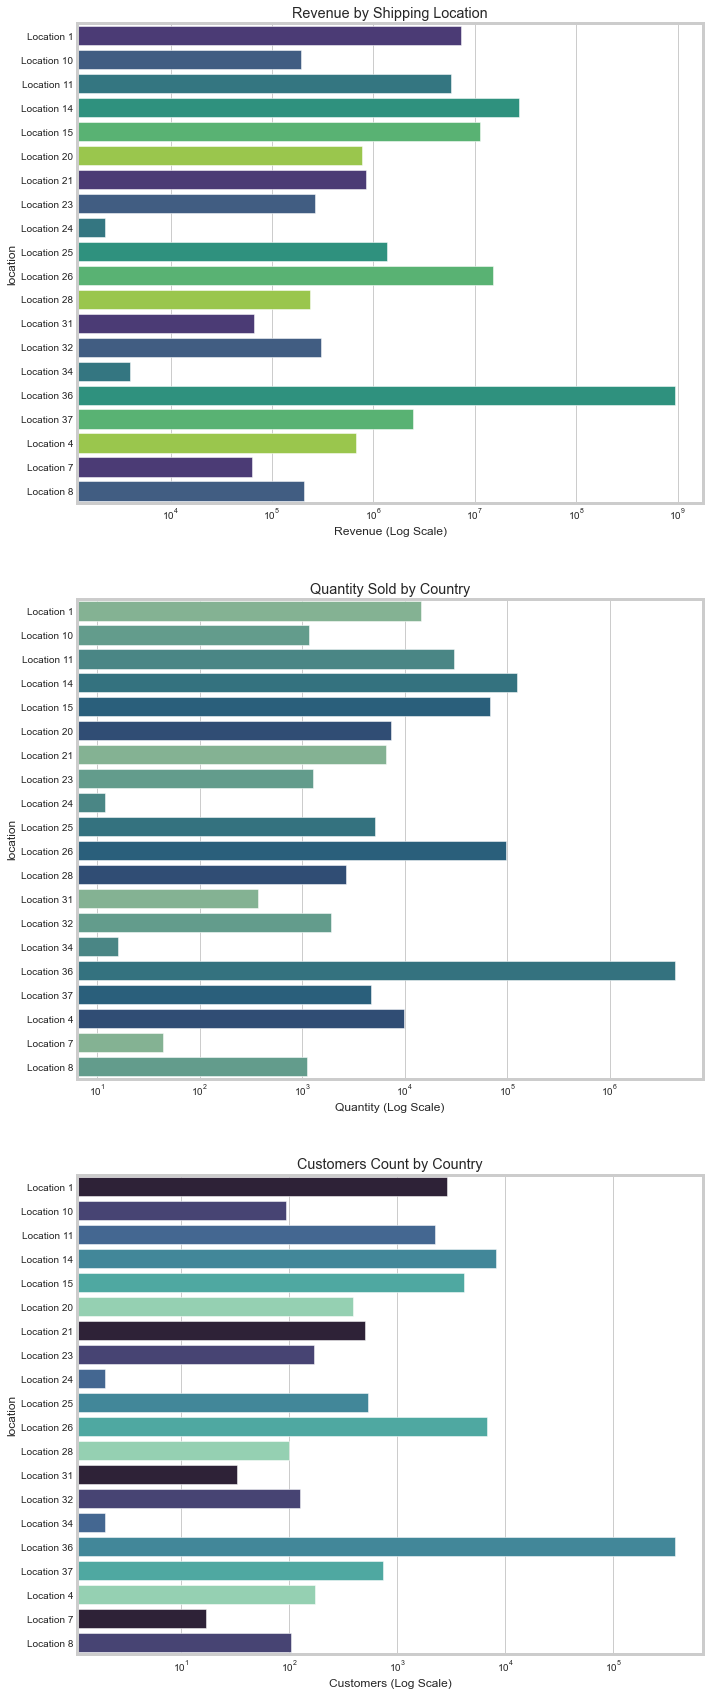

In [29]:
# Now, we are going to check how the other locations are doing

#Again creating a dataframe with only positive values
region = fullRaw[fullRaw['total_sales']>=0].groupby('location').agg({'total_sales':'sum',
                                                  'quantity': 'sum',
                                                  'customer_id': 'count'})

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,30))
g1 = sns.barplot(x=region['total_sales'], y=region.index, alpha=1, ax=ax[0], palette = sns.color_palette("viridis"), orient='h')
ax[0].title.set_text('Revenue by Shipping Location')
ax[0].set_xlabel("Revenue (Log Scale)")
g1.set_xscale("log")

g2 = sns.barplot(x=region['quantity'], y=region.index, alpha=1, ax=ax[1], palette=sns.color_palette("crest"),orient='h')
ax[1].title.set_text('Quantity Sold by Country')
ax[1].set_xlabel("Quantity (Log Scale)")
g2.set_xscale("log")

g3 = sns.barplot(x=region['customer_id'], y=region.index, alpha=1, ax=ax[2], palette=sns.color_palette("mako"), orient='h')
ax[2].title.set_text('Customers Count by Country')
ax[2].set_xlabel("Customers (Log Scale)")
g3.set_xscale("log")
plt.show()

As seen in the graphs, Location 36 still shows the highest count in terms of Customer Count, Quantity and Revenue, followed by Location 26.

### Analysis 'total_sales' & 'quantity' quarter wise 

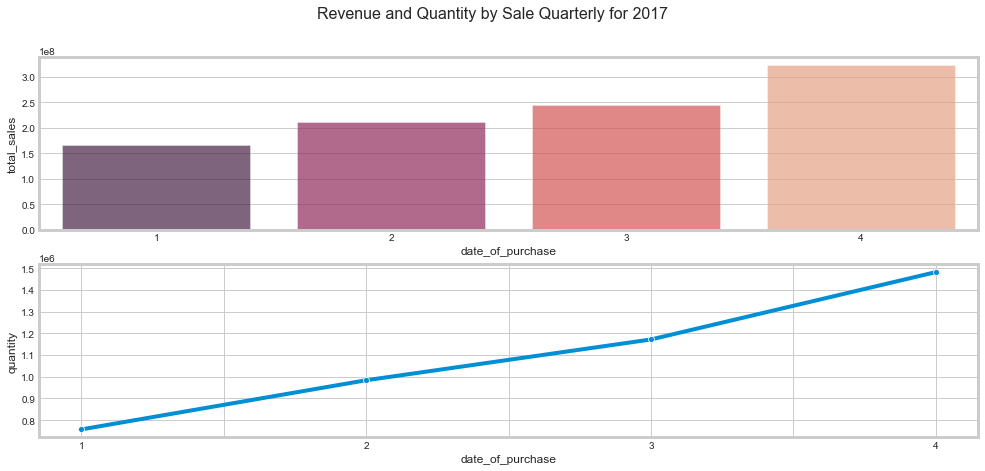

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

quarter = fullRaw[(fullRaw['total_sales']>=0)&(fullRaw['date_of_purchase'].dt.year==2017)][['date_of_purchase','total_sales','quantity']]
quarter = quarter.groupby(quarter['date_of_purchase'].dt.quarter)[['total_sales','quantity']].sum()

sns.barplot(data = quarter, x=quarter.index, y='total_sales', alpha=0.7, ax=ax[0], palette = 'rocket')
sns.lineplot(data = quarter, x=quarter.index, y='quantity', marker='o', sort = False, ax=ax[1])
fig.suptitle('Revenue and Quantity by Sale Quarterly for 2017',fontsize=16)

ax[1].set_xticklabels(['',1,'',2,'',3,'',4])
plt.show()

The last quarter of 2017 witness higher 'total_sales' and higher 'quantity'

In [31]:
# The years present in the dataset are: 
print('Years present in the dataset:')
print(fullRaw['year'].unique())

Years present in the dataset:
[2017 2016]


###  =======================================================================================

## RFM Technique


Instead of using the fullRaw column, we created separate dataframes for each variable. These variables have been detected with outliers and removed.

 ## Recency
 
 For RFM Technique, 'R' stands for Recency, that is how recently a customer has brought a product.

In [32]:
# To capture the Recency, we used 'customer_id', that is the unique identifier in this case along with the date of
# purchase. The lower the value, the better the recency. 
df_recency = fullRaw.groupby(by='customer_id',
                        as_index=False)['date_of_purchase'].max()
df_recency.columns = ['customer_id', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
df_recency.head()

,customer_id,LastPurchaseDate,Recency
0,2.0,2017-12-16,3
1,3.0,2017-10-04,76
2,4.0,2017-12-01,18
3,5.0,2017-02-12,310
4,6.0,2017-11-13,36


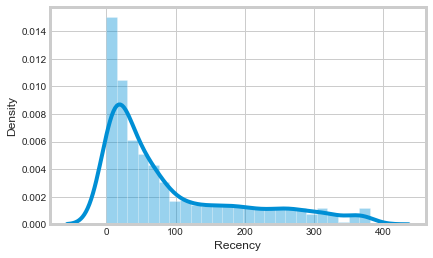

In [33]:
# Here, you see that the data is skewed to the right. We will perform operations to make the data more symmetric 
# for the three variables.
sns.distplot(df_recency['Recency']);

## Frequency

 For RFM Technique, 'F' stands for Frequency, that is how frequently a customer has brought a product.


In [34]:
# To capture the Frequency, we used 'customer_id', that is the unique identifier in this case along with 'invoice_no'.
# The higher the value, the better the frequency. 

frequency_df = fullRaw.drop_duplicates().groupby(by=['customer_id'], as_index=False)['invoice_no'].count()
frequency_df.columns = ['customer_id', 'Frequency']
frequency_df.head()

,customer_id,Frequency
0,2.0,182
1,3.0,27
2,4.0,72
3,5.0,16
4,6.0,84


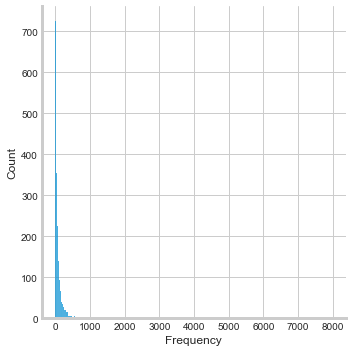

In [36]:
# Even this is skewed to the right.

sns.displot(frequency_df['Frequency']);

## Monetary 

For RFM Technique, 'M' stands for Monetary, that is the total amount of money a customer has spent on a product over a period of time.

In [37]:
# To capture the Monetary, we used 'customer_id', that is the unique identifier in this case along with the sum 
# of'total_sales'. The higher the value, the better the Monetary. 

monetary_df = fullRaw.groupby(by='customer_id', as_index=False)['total_sales'].sum()
monetary_df.columns = ['customer_id', 'Monetary']
monetary_df.head()

,customer_id,Monetary
0,2.0,553704.0
1,3.0,257404.0
2,4.0,176613.0
3,5.0,41976.0
4,6.0,151822.0


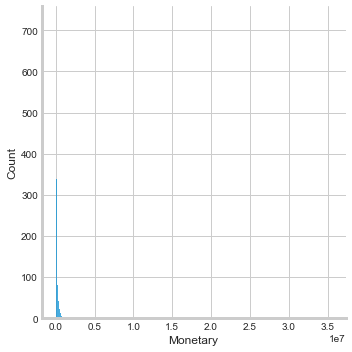

In [38]:
sns.displot(monetary_df['Monetary']);

In [39]:
# Now, three of the variables are merged on basis of the 'customer_id'
rf_df = df_recency.merge(frequency_df, on='customer_id')
rfm_df = rf_df.merge(monetary_df, on='customer_id').drop(
    columns='LastPurchaseDate')

rfm_df.head()

,customer_id,Recency,Frequency,Monetary
0,2.0,3,182,553704.0
1,3.0,76,27,257404.0
2,4.0,18,72,176613.0
3,5.0,310,16,41976.0
4,6.0,36,84,151822.0


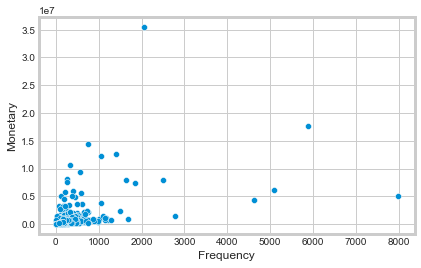

In [40]:
# The scatterplot here shows the relation between two variables. As the F increases, M increases most of the time.

sns.scatterplot(rfm_df['Frequency'],rfm_df['Monetary']);

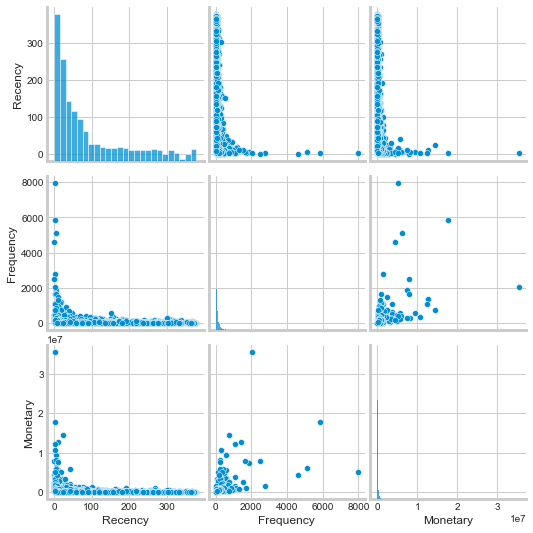

In [41]:
# To understand the pairwise relationships.
sns.pairplot(rfm_df[['Recency','Frequency','Monetary']]);

In [42]:
# Ranking three of the variables. 
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

# Using the percentile method to limit the RFM between [0,100], hence normalising the data
rfm_df['R_rank_perc'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_perc'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_perc'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100

rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

rfm_df.head()

,customer_id,Recency,Frequency,Monetary,R_rank_perc,F_rank_perc,M_rank_perc
0,2.0,3,182,553704.0,94.696795,87.962750,87.962750
1,3.0,76,27,257404.0,37.802629,36.744079,36.744079
2,4.0,18,72,176613.0,73.829836,65.911704,65.911704
3,5.0,310,16,41976.0,5.453078,23.246723,23.246723
4,6.0,36,84,151822.0,57.551303,69.774661,69.774661


In [43]:
# Since each of the variable may have separate effect on the final analysis, we use the weighted summatation to 
# give equal influence to each variable.

rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_perc']+0.28 * \
    rfm_df['F_rank_perc']+0.57*rfm_df['M_rank_perc']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['customer_id', 'RFM_Score']].head(7)


,customer_id,RFM_Score
0,2.0,4.45
1,3.0,1.85
2,4.0,3.35
3,5.0,1.03
4,6.0,3.40
5,7.0,0.33
6,8.0,2.65


In [44]:
rfmmax=rfm_df.RFM_Score.max()
rfmmin=rfm_df.RFM_Score.min()
print("The max score is",rfmmax, "and the min score is",rfmmin)

The max score is 5.0 and the min score is 0.04


## The customer segmentation here is done according to the RFM Scores that is the summation of RFM. 
 
 => High Value Customers: When R, F, M are the highest
 
 => Medium Value Customers: When
 
 => Low Value Customers: When

 => Lost Customers: When R, F, M are lowest 

In [46]:
# Dividing the Data into equal quartiles with a difference of 0.25 didn't help us, we tried other combinations 
# with differences of 0.30, 0.20, 0.35, but none of them worked so for RFM_Scores from descending order, 
# we took values with 0.20 difference each for the first two and the next two categories have a difference of
# 0.30

quartiles=list(rfm_df['RFM_Score'].quantile([0.30,0.60,0.80]))
quartiles

[1.56, 2.95, 3.88]

In [45]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] > 3.88,"High value Customer",(np.where(rfm_df['RFM_Score'] > 2.95,"Medium Value Customer",np.where(rfm_df['RFM_Score'] > 1.56,'Low Value Customers', 'Lost Customers'))))
rfm_df[['customer_id', 'RFM_Score', 'Customer_segment']].head(20)

,customer_id,RFM_Score,Customer_segment
0,2.0,4.45,High value Customer
1,3.0,1.85,Low Value Customers
2,4.0,3.35,Medium Value Customer
3,5.0,1.03,Lost Customers
4,6.0,3.40,Medium Value Customer
5,7.0,0.33,Lost Customers
6,8.0,2.65,Low Value Customers
7,9.0,0.92,Lost Customers
8,10.0,3.05,Medium Value Customer
9,11.0,3.90,High value Customer


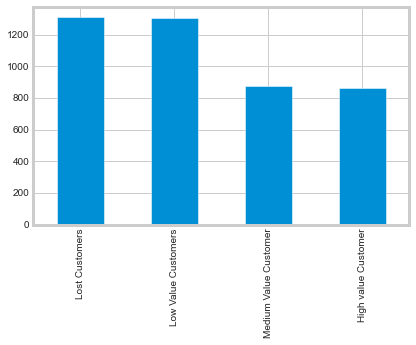

In [46]:
rfm_df['Customer_segment'].value_counts().plot(kind="bar");

In [49]:
# Percentage Distribution of the 'Customer_segments'
cust_seg_perc=(rfm_df['Customer_segment'].value_counts()/rfm_df.shape[0])*100
print(f'{cust_seg_perc.round(2)}%')

Lost Customers           30.08
Low Value Customers      30.03
Medium Value Customer    20.10
High value Customer      19.80
Name: Customer_segment, dtype: float64%


In [48]:
# 4 segments after clustering based on RFM score
rfm_df['Customer_segment'].value_counts()

Lost Customers           1308
Low Value Customers      1306
Medium Value Customer     874
High value Customer       861
Name: Customer_segment, dtype: int64

The conclusion we can draw from here is that around ~30.7% of the customers are 'Lost Customers' and around ~30.5% are 'Low Value Customers'. The percentage of 'High value Customer' is only around ~18% which is quite low enough. The Marketing Department should hence focus on a lot of marketing strategies that will specifically Lost and Low Value Customers.

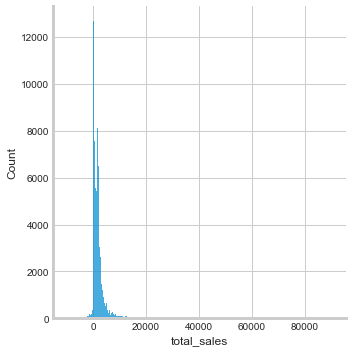

In [51]:
# Distribution of 'total_sales'
sns.displot(fullRaw['total_sales']);

#### Standardisation or Data Normalisation

In [52]:
rfm_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,4349.000000,4349.000000,4.349000e+03
mean,92.299379,92.936537,2.299380e+05
std,100.701315,232.086935,8.572589e+05
min,0.000000,1.000000,-5.037200e+04
25%,17.000000,17.000000,3.814800e+04
50%,50.000000,42.000000,8.365500e+04
75%,143.000000,101.000000,2.056120e+05
max,380.000000,7970.000000,3.553619e+07


In [53]:
rfm_df = rfm_df[rfm_df['Monetary'] > 0]
rfm_df.reset_index(drop=True,inplace=True)
#There is no 0 in the monetary column

In [54]:
# Creating new dataframe with RFM
rawDF=rfm_df[['Recency','Frequency','Monetary']]

As discussed above, when the data is right skewed, one of the methods to make the data symmetrical is Cube Transformation or even Log Transformation, but for this data, we found Cube Transformation perform better

In [56]:
# Perfoming the cube root function (x)= x**3
data_cbrt = np.cbrt(rawDF)
data_cbrt=pd.DataFrame(data_cbrt,columns=rawDF.columns)

In [57]:
# Saving the file
data_cbrt.to_csv('cbrt_data.csv',index=False)

In case, you want to use Log Transformation

In [59]:
# data_log = np.log(rawDF + (1- min(rawDF)))
# data_log = np.log(rawDF)
# data_log=pd.DataFrame(data_log,columns=rawDF.columns)

In [58]:
to_cbrt = ['Recency', 'Frequency','Monetary']
df_cbrt = rawDF[to_cbrt].applymap(lambda x: np.cbrt(x))

Standardization does not change the skew of the distribution. What it does is transforming the values so it has μ=0 and σ2=1. The actual distribution shape remains unchanged.

In [59]:
# Initialize a standard scaler and fit it
scaler = StandardScaler()
# scaler.fit(df_log)
scaler.fit(df_cbrt)

# data_normalized = scaler.transform(df_log)
data_normalized = scaler.transform(df_cbrt)

# Create a pandas DataFrame
# data_norm = pd.DataFrame(df_log, index=rawDF.index, columns=rawDF.columns)
data_norm = pd.DataFrame(df_cbrt, index=rawDF.index, columns=rawDF.columns)

data_norm.to_csv('cbrt_transformation.csv',index=False)

In [62]:
###################################################################################################################
# Another method we used was performing only standardization but that did not give an optimal output in comparison
##################################################################################################################

# Only standardization #

# scaler = StandardScaler()
# scaler.fit(rawDF)

# data_normalized = scaler.transform(rawDF)

# Create a pandas DataFrame #
# data_norm = pd.DataFrame(rawDF, index=rawDF.index, columns=rawDF.columns)
# data_norm.to_csv('logx+1.csv',index=False)

In [60]:
data_norm.head()

,Recency,Frequency,Monetary
0,1.442250,5.667051,82.115641
1,4.235824,3.000000,63.611909
2,2.620741,4.160168,56.105774
3,6.767899,2.519842,34.753644
4,3.301927,4.379519,53.347193


In [61]:
((data_norm[data_norm['Recency']==0].value_counts().sum()/data_norm.shape[0])*100).round(2)
# Recency with 0 is 0.5% in data.

0.58

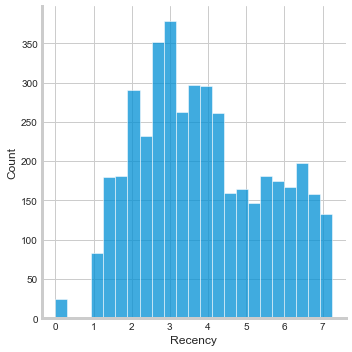

In [63]:
sns.displot(data_norm['Recency']);

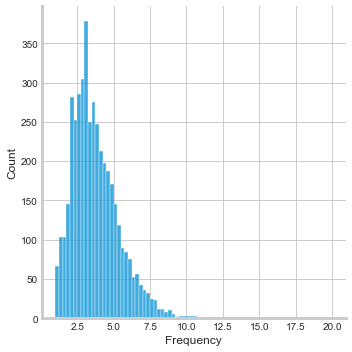

In [64]:
sns.displot(data_norm['Frequency']);

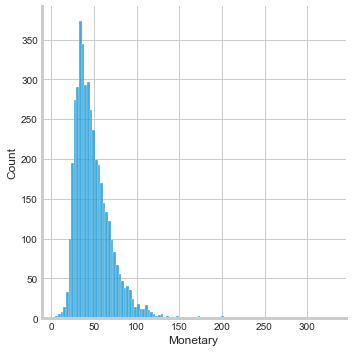

In [65]:
sns.displot(data_norm['Monetary']);

As you can see, with Cube Root Transformation and Standard Scalar, the data shows a normal distribution for all the 
three variables

In [66]:
data_norm.describe()

,Recency,Frequency,Monetary
count,4319.000000,4319.000000,4319.000000
mean,3.857020,3.777669,49.169487
std,1.678673,1.687737,23.375830
min,0.000000,1.000000,4.578857
25%,2.571282,2.620741,33.791398
50%,3.684031,3.476027,43.962261
75%,5.192494,4.672329,59.137568
max,7.243156,19.974969,328.768579


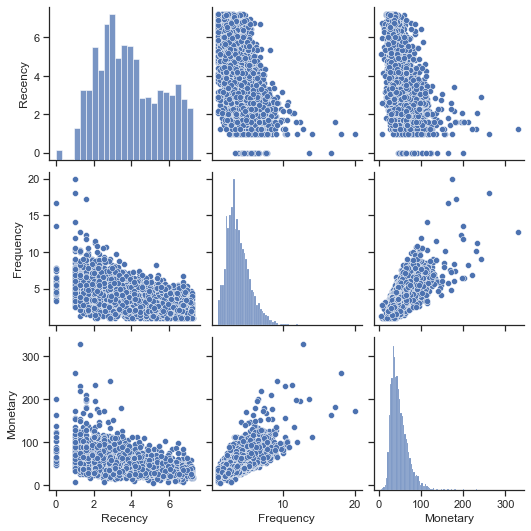

In [67]:
sns.set_theme(style="ticks")
sns.pairplot(data_norm,);

# Machine Learning Algorithms : Unsupervised

### Clustering with K-means algorithm
Using the RFM data (data_norm), will try to find out the optimal number of clusters in our data using the elbow method.

In [68]:
from sklearn.cluster import KMeans
wss=[]
for k in range(1,10):
    kmeans = KMeans(n_clusters = k, random_state=2408).fit(data_norm)
    wss.append(kmeans.inertia_)

In [69]:
wss

[2383949.7400901113,
 1036336.2962963096,
 604228.4840851128,
 367426.8997720879,
 245098.5416763187,
 185495.26822318055,
 144489.49607476004,
 119052.38828851862,
 95692.13580689755]

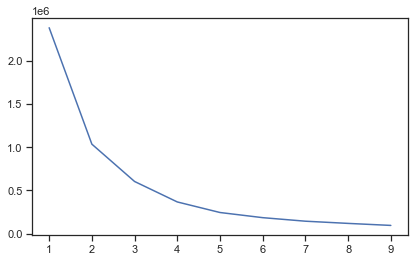

In [70]:
#ploting a line graph
sns.lineplot(x=range(1,10),y=wss);

#### Model Building

In [71]:
# With 3 clusters
kmeans = KMeans(n_clusters=3, random_state=2408)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [72]:
# Create a cluster label column in the original DataFrame
data_norm_k3 = data_norm.assign(Cluster = cluster_labels)
data_k3 = rawDF.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
k3 = data_k3.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'Monetary': ['mean', 'count'],}).round(0)

k3

Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0         120.0      35.0    54322.0  2735
1          43.0     153.0   313973.0  1428
2          15.0     581.0  2585172.0   156

In [73]:
# With 4 clusters
kmeans1 = KMeans(n_clusters=4, random_state=2408)

# Compute k-means clustering on pre-processed data
kmeans1.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans1.labels_
cluster_labels

array([1, 2, 2, ..., 0, 2, 2])

In [74]:
# Create a cluster label column in the original DataFrame
data_norm_k4 = data_norm.assign(Cluster = cluster_labels)
data_k4 = rawDF.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
k4 = data_k4.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'Monetary': ['mean', 'count'],}).round(0)

k4

Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0         131.0      28.0    42101.0  2239
1          26.0     287.0   747014.0   502
2          56.0     100.0   188673.0  1545
3           8.0    1278.0  7255908.0    33

In [75]:
# Cluster sizes
display(k3)
display(k4)
# From here, we can see that 4 clusters shows better clustering

Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0         120.0      35.0    54322.0  2735
1          43.0     153.0   313973.0  1428
2          15.0     581.0  2585172.0   156

Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0         131.0      28.0    42101.0  2239
1          26.0     287.0   747014.0   502
2          56.0     100.0   188673.0  1545
3           8.0    1278.0  7255908.0    33

In [76]:
data_norm_k4.index = rfm_df['customer_id'].astype(int)

In [80]:
#data_norm_k4['Cluster'].replace({0:'Low Value Customers',
 #                        1:'Medium Value Customers',
  #                       2:'High Value Customers',
   #                      3:'Lost Customers'},inplace=True)

In [77]:
data_norm_k4['Cluster'].replace({0:'Lost Customers',
                          1:'Medium Value Customers',
                          2:'Low Value Customers',
                          3:'High Value Customers'},inplace=True)

In [78]:
data_norm_k4.head(10)

,Recency,Frequency,Monetary,Cluster
customer_id,,,,
2,1.442250,5.667051,82.115641,Medium Value Customers
3,4.235824,3.000000,63.611909,Low Value Customers
4,2.620741,4.160168,56.105774,Low Value Customers
5,6.767899,2.519842,34.753644,Lost Customers
6,3.301927,4.379519,53.347193,Low Value Customers
7,5.915482,1.587401,21.112024,Lost Customers
8,6.144634,3.870877,51.368850,Low Value Customers
9,5.981424,2.351335,40.378082,Lost Customers
10,2.884499,3.870877,69.215805,Low Value Customers


In [79]:
# Cluster percentage in k=4
((data_norm_k4['Cluster'].value_counts()/data_norm_k4.shape[0])*100).round(2)

Lost Customers            51.84
Low Value Customers       35.77
Medium Value Customers    11.62
High Value Customers       0.76
Name: Cluster, dtype: float64

In [80]:
data_norm_k4['Cluster'].value_counts()

Lost Customers            2239
Low Value Customers       1545
Medium Value Customers     502
High Value Customers        33
Name: Cluster, dtype: int64

In [81]:
LostCust=(data_norm_k4[data_norm_k4['Cluster']=='Lost Customers'])
LowValCust=(data_norm_k4[data_norm_k4['Cluster']=='Low Value Customers'])
MediumValCust=(data_norm_k4[data_norm_k4['Cluster']=='Medium Value Customers'])
HighValCust=(data_norm_k4[data_norm_k4['Cluster']=='High Value Customers'])
LostCust.shape,LowValCust.shape,MediumValCust.shape,HighValCust.shape
# MediumValCust.to_csv("MediumvalueCust.csv")
# data_norm_k4.to_csv("dataNorm.csv")

((2239, 4), (1545, 4), (502, 4), (33, 4))

In [82]:
data_norm_k4.head()

,Recency,Frequency,Monetary,Cluster
customer_id,,,,
2,1.442250,5.667051,82.115641,Medium Value Customers
3,4.235824,3.000000,63.611909,Low Value Customers
4,2.620741,4.160168,56.105774,Low Value Customers
5,6.767899,2.519842,34.753644,Lost Customers
6,3.301927,4.379519,53.347193,Low Value Customers


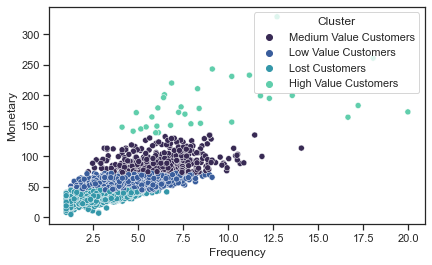

In [85]:
# Frequency vs Monetary
sns.scatterplot(x = 'Frequency', y = 'Monetary',  data = data_norm_k4, 
                hue = "Cluster", palette = "mako");#["red", "green", "blue","yellow"])
# sns.set_theme(style="whitegrid", palette="muted")
# ax = sns.swarmplot(data=data_norm_k4, x="Frequency", y="Monetary", hue="Cluster")
# ax.set(ylabel="")

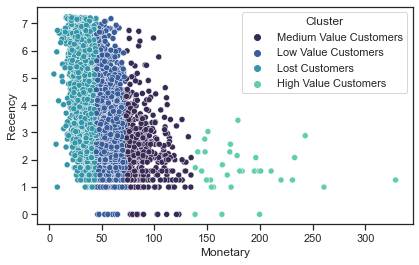

In [87]:
# Monetary vs Recency
sns.scatterplot(x = 'Monetary', y = 'Recency',  
                data = data_norm_k4, hue = "Cluster", palette = "mako");#["red", "green", "blue","yellow"])

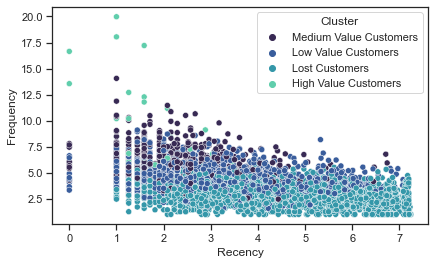

In [88]:
# Recency vs Frequency
sns.scatterplot(x = 'Recency', y = 'Frequency',  
                data = data_norm_k4, hue = "Cluster", palette = "mako");#["red", "green", "blue","yellow"])

In [89]:
# Melt the data into along format so RFM values and metric names are stored in 1 column each
data_melt = pd.melt(data_norm_k4.reset_index(),
                    id_vars=['customer_id', 'Cluster'],
                    value_vars=['Recency', 'Frequency'],
                    var_name='Attribute',
                    value_name='Value')

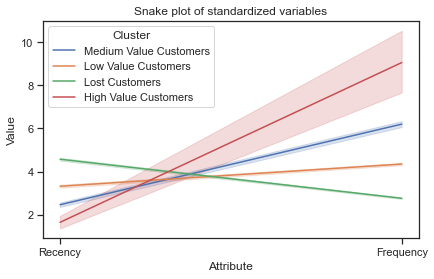

In [90]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=data_melt);

Here, using the snake plot, we can see that Recency is almost the same throughout, but very slight difference. Frequency 

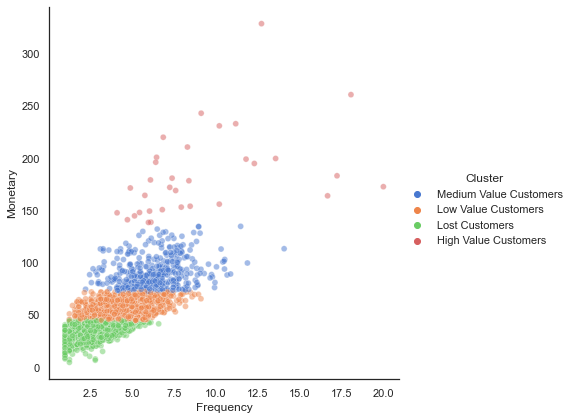

In [91]:
sns.set_theme(style="white")
# Plot monetary against frequency 
sns.relplot(x="Frequency", y="Monetary", hue="Cluster",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=data_norm_k4);

Clustering validation using silhouette value

In [92]:
data_k4.index = rfm_df['customer_id'].astype(int)
data_k4.head()

,Recency,Frequency,Monetary,Cluster
customer_id,,,,
2,3,182,553704.0,1
3,76,27,257404.0,2
4,18,72,176613.0,2
5,310,16,41976.0,0
6,36,84,151822.0,2


In [94]:
# Since we built our clustering model using standardized data, we will have to validate our clustering model 
# using the same datset.
# Combine cluster info with the standardized data
FullRaw2=data_norm_k4.copy()
FullRaw2.head()

,Recency,Frequency,Monetary,Cluster
customer_id,,,,
2,1.442250,5.667051,82.115641,Medium Value Customers
3,4.235824,3.000000,63.611909,Low Value Customers
4,2.620741,4.160168,56.105774,Low Value Customers
5,6.767899,2.519842,34.753644,Lost Customers
6,3.301927,4.379519,53.347193,Low Value Customers


In [95]:
FullRaw2['Cluster'].replace({'Low Value Customers':0,
                         'Medium Value Customers':1,
                         'High Value Customers':2,
                         'Lost Customers':3},inplace=True)

In [96]:
FullRaw2.shape,data_norm_k4.shape

((4319, 4), (4319, 4))

In [97]:
FullRaw2['Silhouette_value']=silhouette_samples(FullRaw2,kmeans.labels_)
FullRaw2.head()

,Recency,Frequency,Monetary,Cluster,Silhouette_value
customer_id,,,,,
2,1.442250,5.667051,82.115641,1,0.585865
3,4.235824,3.000000,63.611909,0,0.645126
4,2.620741,4.160168,56.105774,0,0.438001
5,6.767899,2.519842,34.753644,3,0.750933
6,3.301927,4.379519,53.347193,0,0.251419


In [98]:
#cluster-wise silhouette scores
FullRaw2.groupby(['Cluster'])['Silhouette_value'].mean()

Cluster
0    0.431888
1    0.488434
2    0.444269
3    0.703186
Name: Silhouette_value, dtype: float64

In [99]:
#overall silhouette score
silhouette_score(FullRaw2,kmeans.labels_).round(2)

0.58

In [100]:
 print(FullRaw2.groupby(['Cluster'])["Silhouette_value"].count())

Cluster
0    1545
1     502
2      33
3    2239
Name: Silhouette_value, dtype: int64


In [101]:
sum(FullRaw2.groupby(['Cluster'])["Cluster"].count() * FullRaw2.groupby(['Cluster'])['Silhouette_value'].mean())/FullRaw2.shape[0]

0.5791978972749786

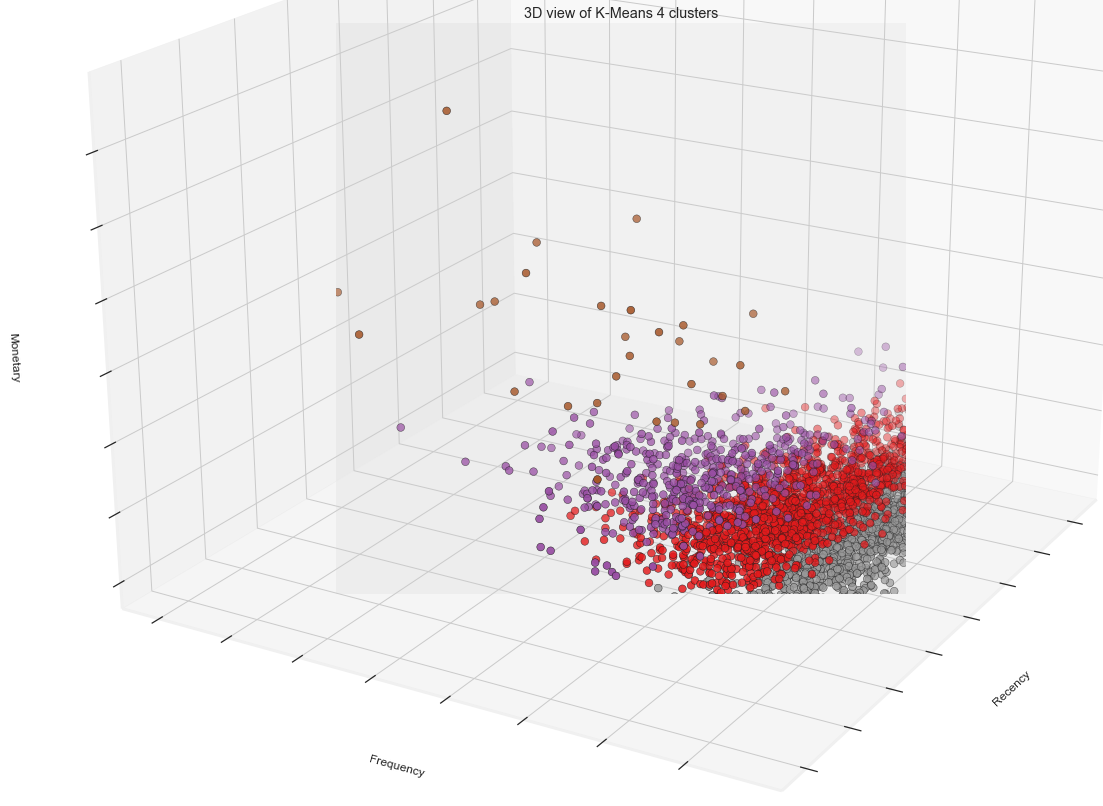

In [102]:
# View 1


fig = plt.figure(figsize=(8, 20))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(FullRaw2['Recency'],
           FullRaw2['Frequency'],
           FullRaw2['Monetary'],
           c=FullRaw2['Cluster'],
           s=60, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D view of K-Means 4 clusters')
ax.dist = 5
auto_add_to_figure=False
fig.add_axes(ax)

plt.show()

If outlier step removed then we get silhouette score of 0.5799, otherwise, we get 0.53

No handles with labels found to put in legend.


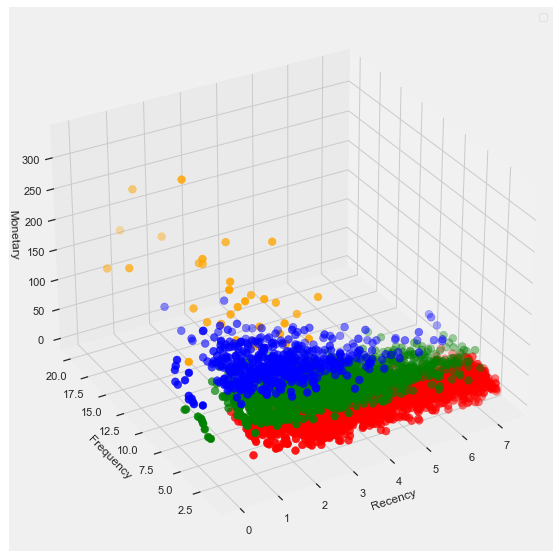

In [107]:
# View 2

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 0], FullRaw2["Frequency"][FullRaw2.Cluster == 0], FullRaw2["Monetary"][FullRaw2.Cluster == 0], c='green', s=60)
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 1], FullRaw2["Frequency"][FullRaw2.Cluster == 1], FullRaw2["Monetary"][FullRaw2.Cluster == 1], c='blue', s=60)
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 2], FullRaw2["Frequency"][FullRaw2.Cluster == 2], FullRaw2["Monetary"][FullRaw2.Cluster == 2], c='orange', s=60)
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 3], FullRaw2["Frequency"][FullRaw2.Cluster == 3], FullRaw2["Monetary"][FullRaw2.Cluster == 3], c='red', s=60)
# ax.scatter([FullRaw2.Cluster == 4], c='purple', s=60)
ax.view_init(30, 600)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
ax.legend()
plt.show()

No handles with labels found to put in legend.


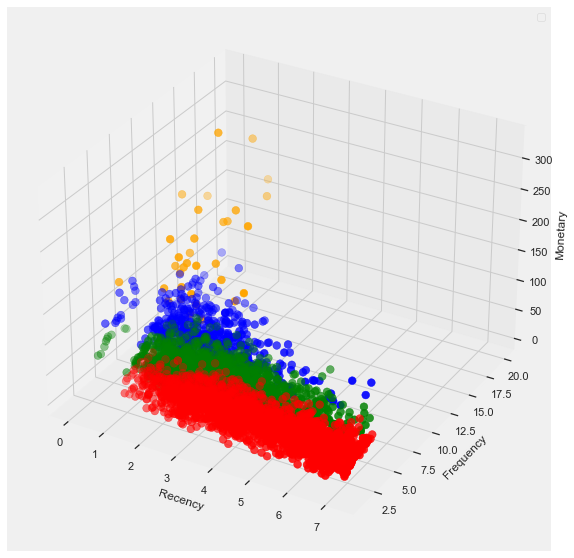

In [108]:
# View 3
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 0], FullRaw2["Frequency"][FullRaw2.Cluster == 0], FullRaw2["Monetary"][FullRaw2.Cluster == 0], c='green', s=60)
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 1], FullRaw2["Frequency"][FullRaw2.Cluster == 1], FullRaw2["Monetary"][FullRaw2.Cluster == 1], c='blue', s=60)
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 2], FullRaw2["Frequency"][FullRaw2.Cluster == 2], FullRaw2["Monetary"][FullRaw2.Cluster == 2], c='orange', s=60)
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 3], FullRaw2["Frequency"][FullRaw2.Cluster == 3], FullRaw2["Monetary"][FullRaw2.Cluster == 3], c='red', s=60)
# ax.scatter([FullRaw2.Cluster == 4], c='purple', s=60)
ax.view_init(30, 300)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
ax.legend()
plt.show()

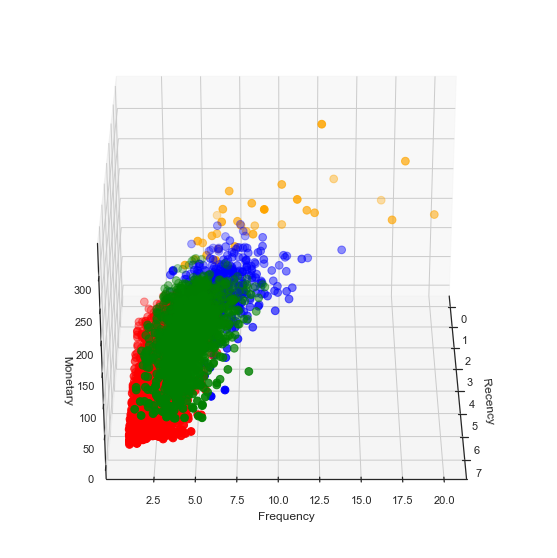

In [106]:
# View 4

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 0], FullRaw2["Frequency"][FullRaw2.Cluster == 0], FullRaw2["Monetary"][FullRaw2.Cluster == 0], c='green', s=60)
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 1], FullRaw2["Frequency"][FullRaw2.Cluster == 1], FullRaw2["Monetary"][FullRaw2.Cluster == 1], c='blue', s=60)
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 2], FullRaw2["Frequency"][FullRaw2.Cluster == 2], FullRaw2["Monetary"][FullRaw2.Cluster == 2], c='orange', s=60)
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 3], FullRaw2["Frequency"][FullRaw2.Cluster == 3], FullRaw2["Monetary"][FullRaw2.Cluster == 3], c='red', s=60)
# ax.scatter([FullRaw2.Cluster == 4], c='purple', s=60)
ax.view_init(30, 00)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.show()

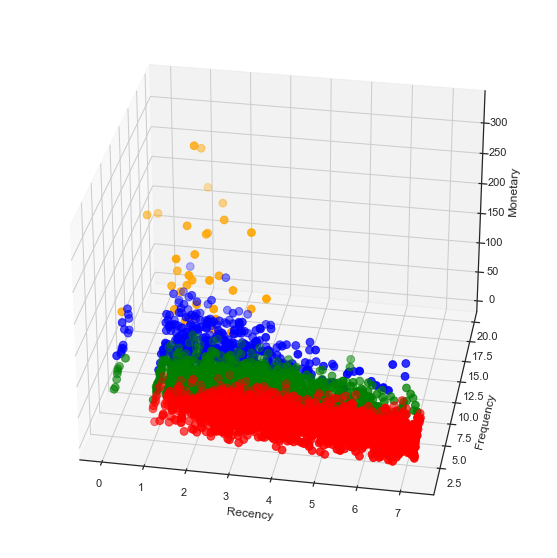

In [107]:
# View 5

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 0], FullRaw2["Frequency"][FullRaw2.Cluster == 0], FullRaw2["Monetary"][FullRaw2.Cluster == 0], c='green', s=60)
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 1], FullRaw2["Frequency"][FullRaw2.Cluster == 1], FullRaw2["Monetary"][FullRaw2.Cluster == 1], c='blue', s=60)
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 2], FullRaw2["Frequency"][FullRaw2.Cluster == 2], FullRaw2["Monetary"][FullRaw2.Cluster == 2], c='orange', s=60)
ax.scatter(FullRaw2.Recency[FullRaw2.Cluster == 3], FullRaw2["Frequency"][FullRaw2.Cluster == 3], FullRaw2["Monetary"][FullRaw2.Cluster == 3], c='red', s=60)
# ax.scatter([FullRaw2.Cluster == 4], c='purple', s=60)
ax.view_init(30, 1000)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.show()

## DBSCAN Clustering

In [110]:
# We are using the data that has normal distribution and standarised. 
# We tried using each separately, but it works
# together in comparison to the separation
db_scaled_features = data_norm.copy()

In [111]:
db_scaled_features

,Recency,Frequency,Monetary
0,1.442250,5.667051,82.115641
1,4.235824,3.000000,63.611909
2,2.620741,4.160168,56.105774
3,6.767899,2.519842,34.753644
4,3.301927,4.379519,53.347193
...,...,...,...
4314,6.518684,2.154435,27.359615
4315,5.646216,1.912931,22.086437
4316,2.000000,2.351335,29.225355
4317,1.442250,9.101727,65.468645


In [112]:
# Since minPts ≥ D + 1, we begin from 4
for eps in [i/10 for i in range(4,14)]:
  for min_samples in range(4,12):
    print("\neps={}".format(eps))
    print("min_samples={}".format(min_samples))
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(db_scaled_features)
    silh = silhouette_score(db_scaled_features, labels)
    print("Clusters present: {}".format(np.unique(labels)))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))
    print("Silhouette Score: {}".format(silh))


eps=0.4
min_samples=4
Clusters present: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121]
Cluster sizes: [2591   17  347   12  116  139    6    6   40   12   38    8    5   22
   13  126   23    5    5   53   44   43   11   15   22    8   25    9
    5    7    8    5   13   10   14    6    5    4    7    4    5   11
    4   10    4   23    7    4    7    9    5   11   25    7    5    4
   10    5    4    6    5    5    4    6    7    4   14    4    4    5
   10    4    5    5    5    5    5    4    5    7    4    4    8    4
    5    4    5   

Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53]
Cluster sizes: [1224 2614   76   87    5    8   14   22    4   14    6    7    3    4
    5   32    8    8    4    4    5    7    7    5    4    8    5    7
    4    5    3    7    6    4    7   10    6    4    4    4    2    4
    4    4    4    5    4    4    5    3    4    4    4    3    4]
Silhouette Score: -0.7093456568164622

eps=0.6
min_samples=5
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30]
Cluster sizes: [1478 2481   14   79    5   65    7   14   13   13    8    8   32    7
    3    6    7    3    7    7    6    5    7    6    4    4    4    5
    5    5    5    6]
Silhouette Score: -0.6867779129904559

eps=0.6
min_samples=6
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23]
Clus

Clusters present: [-1  0  1  2  3  4  5  6  7]
Cluster sizes: [ 546 3681   41   16    7    8    7    6    7]
Silhouette Score: -0.13009011658116562

eps=1.0
min_samples=8
Clusters present: [-1  0  1  2  3  4]
Cluster sizes: [ 589 3662   36   16    8    8]
Silhouette Score: 0.00631662937593933

eps=1.0
min_samples=9
Clusters present: [-1  0  1  2  3]
Cluster sizes: [ 644 3571   34   54   16]
Silhouette Score: 0.32447829802788497

eps=1.0
min_samples=10
Clusters present: [-1  0  1  2  3  4]
Cluster sizes: [ 685 3538   22   50   16    8]
Silhouette Score: 0.31183546552103336

eps=1.0
min_samples=11
Clusters present: [-1  0  1  2  3  4]
Cluster sizes: [ 732 3502   19   28   16   22]
Silhouette Score: 0.2853622869345777

eps=1.1
min_samples=4
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10]
Cluster sizes: [ 287 3949   29    4   14    4    5    8    6    4    5    4]
Silhouette Score: -0.1428997462588394

eps=1.1
min_samples=5
Clusters present: [-1  0  1  2  3  4  5  6  7]
Cluster siz

In [113]:
# With eps=1.2 and min_samples=8
dbscan1 = DBSCAN(eps = 1.2, min_samples=8)
clusters1 = dbscan1.fit_predict(db_scaled_features)

In [114]:
db_scaled_features['dbscan_clusters'] = clusters1

In [115]:
# Combining the cluster info with the dataframe
clusterDf=pd.concat([db_scaled_features,pd.Series(dbscan1.labels_)],axis=1).rename(columns={0:"cluster"})

In [116]:
clusterDf.head(10)

,Recency,Frequency,Monetary,dbscan_clusters,cluster
0,1.442250,5.667051,82.115641,0,0
1,4.235824,3.000000,63.611909,0,0
2,2.620741,4.160168,56.105774,0,0
3,6.767899,2.519842,34.753644,0,0
4,3.301927,4.379519,53.347193,0,0
5,5.915482,1.587401,21.112024,0,0
6,6.144634,3.870877,51.368850,0,0
7,5.981424,2.351335,40.378082,0,0
8,2.884499,3.870877,69.215805,0,0
9,3.207534,5.078753,91.713626,1,1


In [117]:
# Cluster Size
clusterDf['cluster'].value_counts()

 0    3915
-1     375
 1      21
 2       8
Name: cluster, dtype: int64

In [118]:
# Cluster Percentage
clusterDf["cluster"].value_counts(normalize=True)

 0    0.906460
-1    0.086826
 1    0.004862
 2    0.001852
Name: cluster, dtype: float64

In [119]:
# Cluster Profiling
cluster_profileDf=clusterDf.groupby("cluster").mean().reset_index()
cluster_profileDf

,cluster,Recency,Frequency,Monetary,dbscan_clusters
0,-1,2.961309,5.769978,88.255656,-1.0
1,0,3.953820,3.565001,45.097079,0.0
2,1,2.478825,6.718100,92.455231,1.0
3,2,2.089865,6.743809,96.315088,2.0


In [120]:
# Naming the clustering based on RFM values

cluster_profileDf.rename({0:"MediumValueCustomer",
                          1:"LowValueCustomer",
                          2:"HighValueCustomer",
                          3:"LostCustomer"},inplace=True)

cluster_profileDf

,cluster,Recency,Frequency,Monetary,dbscan_clusters
MediumValueCustomer,-1,2.961309,5.769978,88.255656,-1.0
LowValueCustomer,0,3.953820,3.565001,45.097079,0.0
HighValueCustomer,1,2.478825,6.718100,92.455231,1.0
LostCustomer,2,2.089865,6.743809,96.315088,2.0


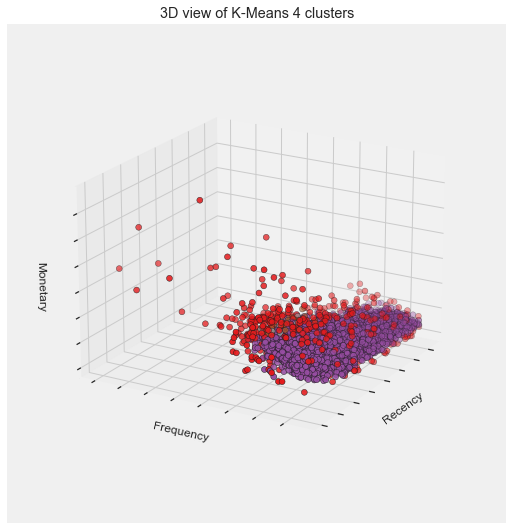

In [121]:
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(db_scaled_features['Recency'],
           db_scaled_features['Frequency'],
           db_scaled_features['Monetary'],
           c=db_scaled_features['dbscan_clusters'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D view of K-Means 4 clusters')
ax.dist = 12

plt.show()

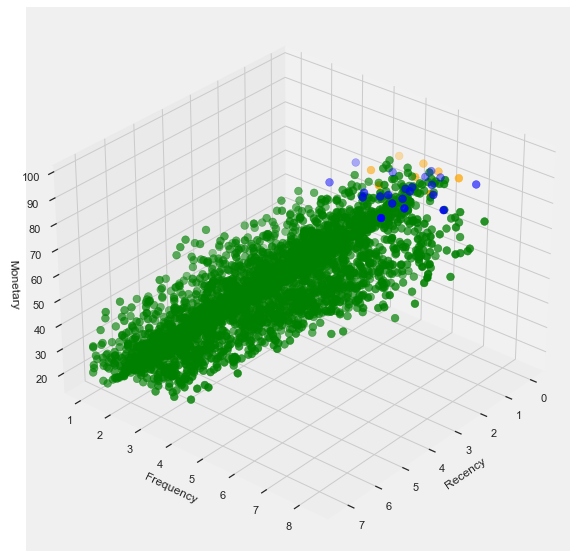

In [123]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(clusterDf.Recency[clusterDf.cluster == 0], clusterDf["Frequency"][clusterDf.cluster == 0], clusterDf["Monetary"][clusterDf.cluster == 0], c='green', s=60)
ax.scatter(clusterDf.Recency[clusterDf.cluster == 1], clusterDf["Frequency"][clusterDf.cluster == 1], clusterDf["Monetary"][clusterDf.cluster == 1], c='blue', s=60)
ax.scatter(clusterDf.Recency[clusterDf.cluster == 2], clusterDf["Frequency"][clusterDf.cluster == 2], clusterDf["Monetary"][clusterDf.cluster == 2], c='orange', s=60)
ax.scatter(clusterDf.Recency[clusterDf.cluster == 3], clusterDf["Frequency"][clusterDf.cluster == 3], clusterDf["Monetary"][clusterDf.cluster == 3], c='red', s=60)
# ax.scatter([clusterDf.cluster == 4], c='purple', s=60)
ax.view_init(30, 400)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.show()

Tried these parameters as well. But it is seen that eps=1.2 and min_samples=9 gives little better clustering than eps=1.2 and min_samples=8

1.2, 8

1.1,9

1.2,11

1.3,7

1.2,9

In [124]:
# With eps=1.2 and min_samples=9
db_scaled_features2=db_scaled_features.copy()
dbscan2 = DBSCAN(eps = 1.2, min_samples=11)
clusters2 = dbscan1.fit_predict(db_scaled_features2)

db_scaled_features2['dbscan_clusters'] = clusters2

In [125]:
# Combining the cluster info with the dataframe
clusterDf2=pd.concat([db_scaled_features2,pd.Series(dbscan1.labels_)],axis=1).rename(columns={0:"cluster"})

clusterDf2.head(10)

,Recency,Frequency,Monetary,dbscan_clusters,cluster
0,1.442250,5.667051,82.115641,0,0
1,4.235824,3.000000,63.611909,0,0
2,2.620741,4.160168,56.105774,0,0
3,6.767899,2.519842,34.753644,0,0
4,3.301927,4.379519,53.347193,0,0
5,5.915482,1.587401,21.112024,0,0
6,6.144634,3.870877,51.368850,0,0
7,5.981424,2.351335,40.378082,0,0
8,2.884499,3.870877,69.215805,0,0
9,3.207534,5.078753,91.713626,1,1


In [126]:
# Cluster Size
clusterDf2['cluster'].value_counts()

# Cluster Percentage
clusterDf2["cluster"].value_counts(normalize=True)

 0    0.906460
-1    0.086826
 1    0.004862
 2    0.001852
Name: cluster, dtype: float64

In [127]:
# Cluster Profiling
cluster_profileDf2=clusterDf2.groupby("cluster").mean().reset_index()
cluster_profileDf2

# Naming the clustering based on RFM values

cluster_profileDf2.rename({0:"MediumValueCustomer",
                          1:"LowValueCustomer",
                          2:"HighValueCustomer",
                          3:"LostCustomer"},inplace=True)

cluster_profileDf2

,cluster,Recency,Frequency,Monetary,dbscan_clusters
MediumValueCustomer,-1,2.961309,5.769978,88.255656,-1.0
LowValueCustomer,0,3.953820,3.565001,45.097079,0.0
HighValueCustomer,1,2.478825,6.718100,92.455231,1.0
LostCustomer,2,2.089865,6.743809,96.315088,2.0


<AxesSubplot:xlabel='Frequency', ylabel='Monetary'>

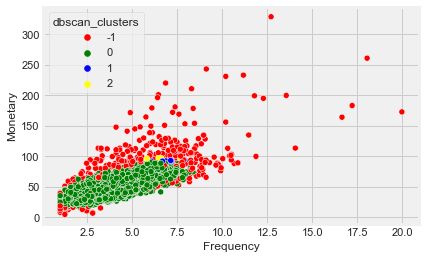

In [128]:
# Frequency vs Monetary

sns.scatterplot(x = 'Frequency', y = 'Monetary',  data = db_scaled_features2, hue = "dbscan_clusters", palette = ["red", "green", "blue","yellow"])


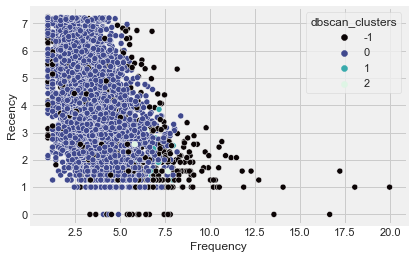

In [129]:
# Frequency vs Recency

sns.scatterplot(x = 'Frequency', y = 'Recency',  data = db_scaled_features2, hue = "dbscan_clusters", 
                palette = "mako"); #["red", "green", "blue","yellow"])


<AxesSubplot:xlabel='Frequency', ylabel='Recency'>

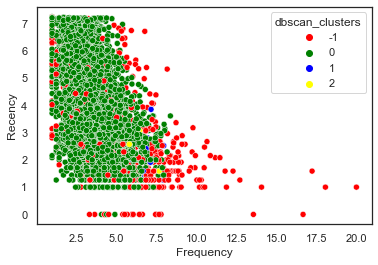

In [128]:
# Recency vs Monetary

sns.scatterplot(x = 'Frequency', y = 'Recency',  data = db_scaled_features2, hue = "dbscan_clusters", palette = ["red", "green", "blue","yellow"])


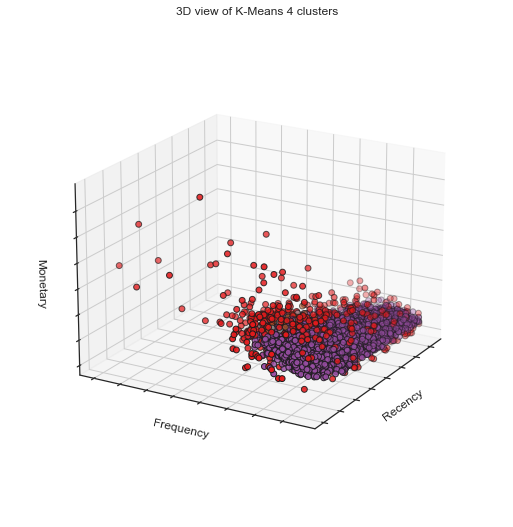

In [129]:
# 3D View 1
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(db_scaled_features2['Recency'],
           db_scaled_features2['Frequency'],
           db_scaled_features2['Monetary'],
           c=db_scaled_features2['dbscan_clusters'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D view of K-Means 4 clusters')
ax.dist = 12

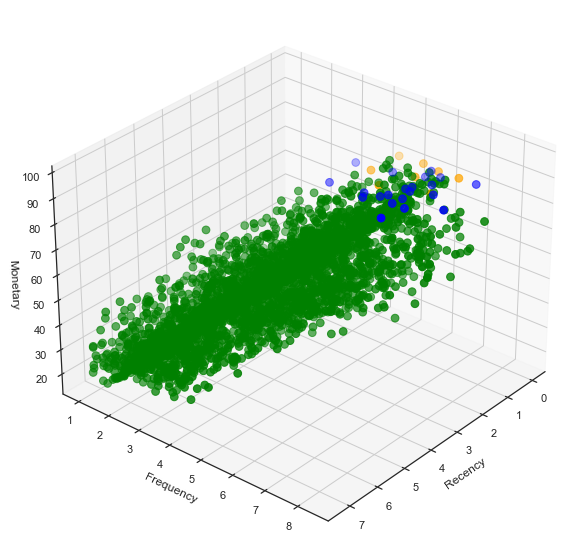

In [130]:
# 3D View 2
plt.show()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 0], clusterDf2["Frequency"][clusterDf2.cluster == 0], clusterDf2["Monetary"][clusterDf2.cluster == 0], c='green', s=60)
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 1], clusterDf2["Frequency"][clusterDf2.cluster == 1], clusterDf2["Monetary"][clusterDf2.cluster == 1], c='blue', s=60)
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 2], clusterDf2["Frequency"][clusterDf2.cluster == 2], clusterDf2["Monetary"][clusterDf2.cluster == 2], c='orange', s=60)
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 3], clusterDf2["Frequency"][clusterDf2.cluster == 3], clusterDf2["Monetary"][clusterDf2.cluster == 3], c='red', s=60)
ax.view_init(30, 400)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.show()

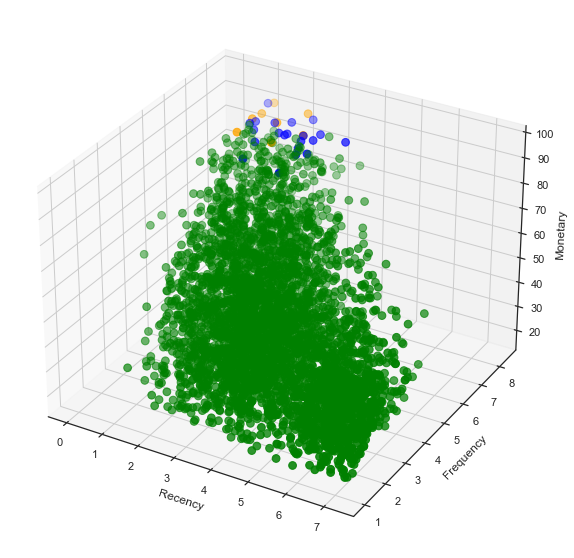

In [131]:
# 3D View 3
plt.show()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 0], clusterDf2["Frequency"][clusterDf2.cluster == 0], clusterDf2["Monetary"][clusterDf2.cluster == 0], c='green', s=60)
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 1], clusterDf2["Frequency"][clusterDf2.cluster == 1], clusterDf2["Monetary"][clusterDf2.cluster == 1], c='blue', s=60)
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 2], clusterDf2["Frequency"][clusterDf2.cluster == 2], clusterDf2["Monetary"][clusterDf2.cluster == 2], c='orange', s=60)
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 3], clusterDf2["Frequency"][clusterDf2.cluster == 3], clusterDf2["Monetary"][clusterDf2.cluster == 3], c='red', s=60)
# ax.scatter([clusterDf2.cluster == 4], c='purple', s=60)
ax.view_init(30, 300)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.show()

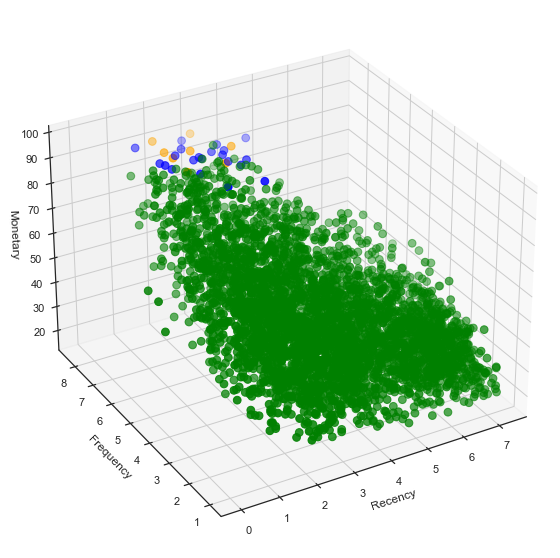

In [132]:
# 3D View 4
plt.show()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 0], clusterDf2["Frequency"][clusterDf2.cluster == 0], clusterDf2["Monetary"][clusterDf2.cluster == 0], c='green', s=60)
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 1], clusterDf2["Frequency"][clusterDf2.cluster == 1], clusterDf2["Monetary"][clusterDf2.cluster == 1], c='blue', s=60)
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 2], clusterDf2["Frequency"][clusterDf2.cluster == 2], clusterDf2["Monetary"][clusterDf2.cluster == 2], c='orange', s=60)
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 3], clusterDf2["Frequency"][clusterDf2.cluster == 3], clusterDf2["Monetary"][clusterDf2.cluster == 3], c='red', s=60)
# ax.scatter([clusterDf2.cluster == 4], c='purple', s=60)
ax.view_init(30, 600)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.show()

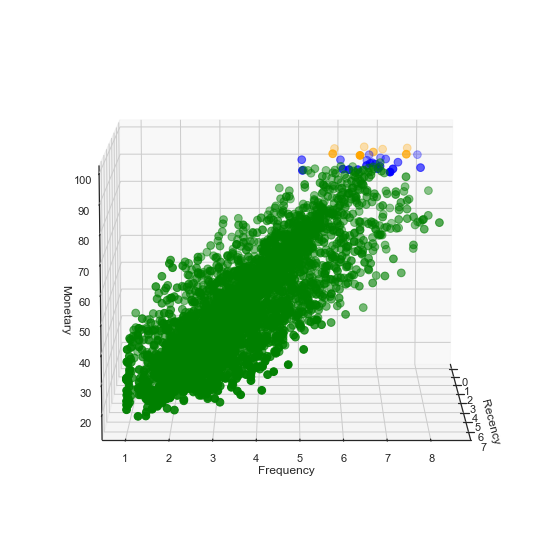

In [134]:
# 3D View 5
plt.show()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 0], clusterDf2["Frequency"][clusterDf2.cluster == 0], clusterDf2["Monetary"][clusterDf2.cluster == 0], c='green', s=60)
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 1], clusterDf2["Frequency"][clusterDf2.cluster == 1], clusterDf2["Monetary"][clusterDf2.cluster == 1], c='blue', s=60)
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 2], clusterDf2["Frequency"][clusterDf2.cluster == 2], clusterDf2["Monetary"][clusterDf2.cluster == 2], c='orange', s=60)
ax.scatter(clusterDf2.Recency[clusterDf2.cluster == 3], clusterDf2["Frequency"][clusterDf2.cluster == 3], clusterDf2["Monetary"][clusterDf2.cluster == 3], c='red', s=60)
# ax.scatter([clusterDf2.cluster == 4], c='purple', s=60)
ax.view_init(0, 00)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.show()

According to both the unsupervised learning algorithmns used for clustering based on RFM, we see that K-means performs better clusters

## Description of the results
Interpretation of the resulting groups:

We chose segmentation for four groups. We may interpret them as the following customer segments:

Group 0: Customers who were shopping for a long time, buy moderately often and they shop for high amounts.

Group 1: Customers who have been shopping recently, they buy often and make purchases for large amounts.

Group 2: Customers who have not been buying anything for a long time, they rarely buy and make purchases for 
relatively small amounts.

Group 3: Customers who have been shopping recently, they rarely buy and make purchases for relatively small amounts.


Based on the received groups we can name them as follows:

Group 0 - former best customers - departing,

Group 1 - best customers - active,

Group 2 - old and random customers - inactive,

Group 3 - new and random customers - new.


Marketing strategies for the customer segments

Based on the 4 clusters, we could formulate marketing strategies relevant to each group:

For the groups 1 and 3 we can apply a typical promotional strategy would focus certain efforts for the high value customers. For the best customers example actions may it be: special offers with discounts, customer cards entitling to benefits (e.g. collecting points redeemed for rewards) or a gift for the next order.

The new clients have not bought from our store before, that's why is worth fighting to transform them into best clients. Example actions for them are: e-mail marketing presenting the advantages of our products, special offers, with discounts for appropriately large purchases.

For the groups 0 and 2 i.e. former best customers and old clients we also can adopt certain marketing strategy. In group 0 (former best clients) include a big customers who for some reason have stopped buying our products, then it is worth trying to renew relations with them hrough an conduct marketing campaign. The group 2 is an old and random customers and here is worth to considering whether we want to carry out some marketing activities.